In [1]:
import dpkt, pcap, socket, collections, numpy
import matplotlib

File:  YouTube.pcap (port: 443, direction: sent)
Number of packets: 603
Time delay: 24.02s
Total size: 132,345 B
Top five lengths: 98 (x220) 94 (x68) 105 (x17) 102 (x17) 90 (x17) 


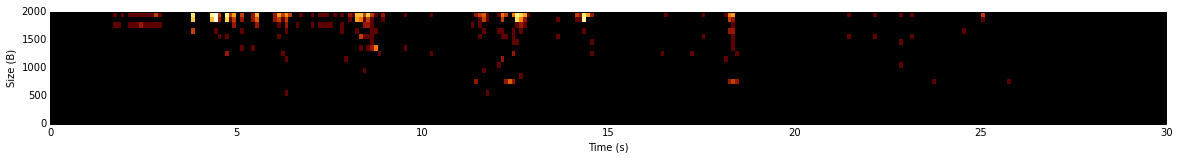

File:  Chameleon.pcap (port: 8080, direction: sent)
Number of packets: 603
Time delay: 24.02s
Total size: 132,345 B
Top five lengths: 98 (x220) 94 (x68) 105 (x17) 102 (x17) 90 (x17) 


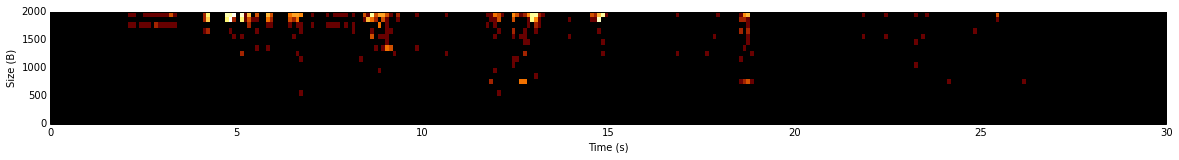

File:  YouTube.pcap (port: 443, direction: received)
Number of packets: 1937
Time delay: 23.99s
Total size: 1,930,262 B
Top five lengths: 1452 (x1020) 98 (x197) 1470 (x101) 90 (x57) 94 (x40) 


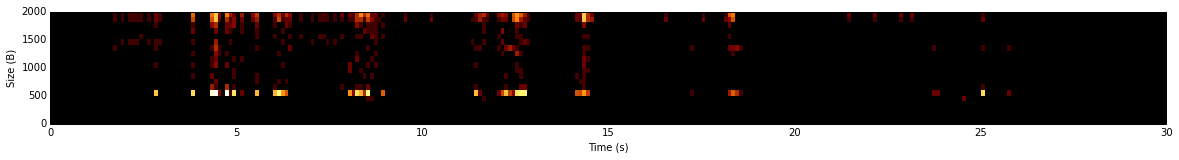

File:  Chameleon.pcap (port: 8080, direction: received)
Number of packets: 1934
Time delay: 23.35s
Total size: 1,926,742 B
Top five lengths: 1452 (x1020) 98 (x197) 1470 (x101) 90 (x57) 94 (x40) 


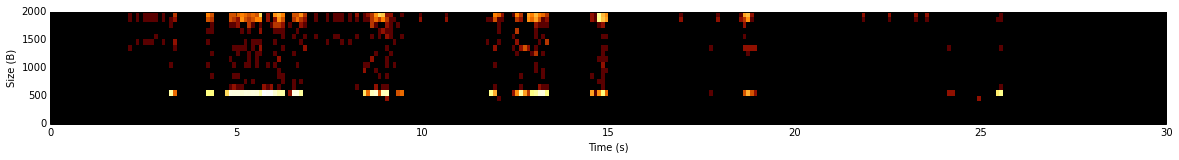

In [85]:
%matplotlib inline

import matplotlib.pyplot as plt

def analyze(fn, port, just_sent):
    pc = pcap.pcap(fn)
    pc.setfilter('tcp') 

    cnt = 0

    max_time = 30

    chart = numpy.zeros((2 * 10, max_time * 10))

    fst = None
    bytes = 0

    times = []
    sizes = collections.defaultdict(int)

    for ts, pkt in pc:
        eth = dpkt.ethernet.Ethernet(pkt)
        ip = eth.data
        tcp = ip.data

        if fst is None:
            fst = ts

        if tcp.dport != port and tcp.sport != port:
            continue

        if len(tcp.data) == 0:
            continue
            
        if ord(tcp.data[0]) != 23:
            continue
        
        from_us = socket.inet_ntoa(ip.src).startswith("128.135.203")

        if from_us != just_sent:
            continue
        
        remote_peer = socket.inet_ntoa(ip.dst if from_us else ip.src)
        # print remote_peer

        chart[len(eth.data) // 100, int((ts - fst) * 1000) / 100] += 1
      
        # print(len(eth.data), ts * 1000 - fst)

        # counts[remote_peer] += len(tcp.data)

        sizes[len(eth.data)] += 1

        bytes += len(eth.data)
        times.append(ts)

    freq = list(reversed(sorted([(b, a) for a, b in sizes.items()])))[:5]
    form = "".join(["{1} (x{0}) ".format(*x) for x in freq])
    print "File: ", fn, "(port: {}, direction: {})".format(port, "sent" if just_sent else "received")
    print "Number of packets: {}".format(len(times))
    if len(times) != 0:
        print "Time delay: {:0.2f}s".format(max(times) - min(times))
    print "Total size: {:,} B".format(bytes)
    if form:
        print "Top five lengths: " + form

    extent = [0, chart.shape[1] / 10, 0, chart.shape[0] * 100]
    
    plt.figure(figsize=(20,2))
    plt.imshow(numpy.log10(1 + chart), interpolation='nearest', cmap=plt.get_cmap("afmhot"), extent=extent, aspect='auto' )
    plt.ylabel("Size (B)")
    plt.xlabel("Time (s)")
    plt.show()

analyze("YouTube.pcap", 443, True)
analyze("Chameleon.pcap", 8080, True)
analyze("YouTube.pcap", 443, False)
analyze("Chameleon.pcap", 8080, False)

In [82]:
pc = pcap.pcap("Dump.pcap")
pc.setfilter('tcp') 

port = 443

fst = None

sent = open("send.csv", "w")
received = open("receive.csv", "w")

for ts, pkt in pc:
    eth = dpkt.ethernet.Ethernet(pkt)
    ip = eth.data
    tcp = ip.data
    
    if fst is None:
        fst = ts
    
    if tcp.dport != port and tcp.sport != port:
        continue
    
    if len(tcp.data) == 0:
        continue
            
    if ord(tcp.data[0]) != 23:
        continue
    
    from_us = socket.inet_ntoa(ip.src).startswith("128.135.203")
    
    if from_us:
        sent.write("{} {}\n".format(len(eth.data), (ts - fst)))
    else:
        received.write("{} {}\n".format(len(eth.data), (ts - fst)))

sent.close()
received.close()

In [54]:
fp = open("track.csv", "w")

for i in xrange(5000):
    fp.write("1452 {}\n".format(float(i) / 200))

fp.close()